# Поиск точек бифуркации временного ряда

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import random
rcParams['figure.figsize'] = 14,6
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### Визуализация алгоритма

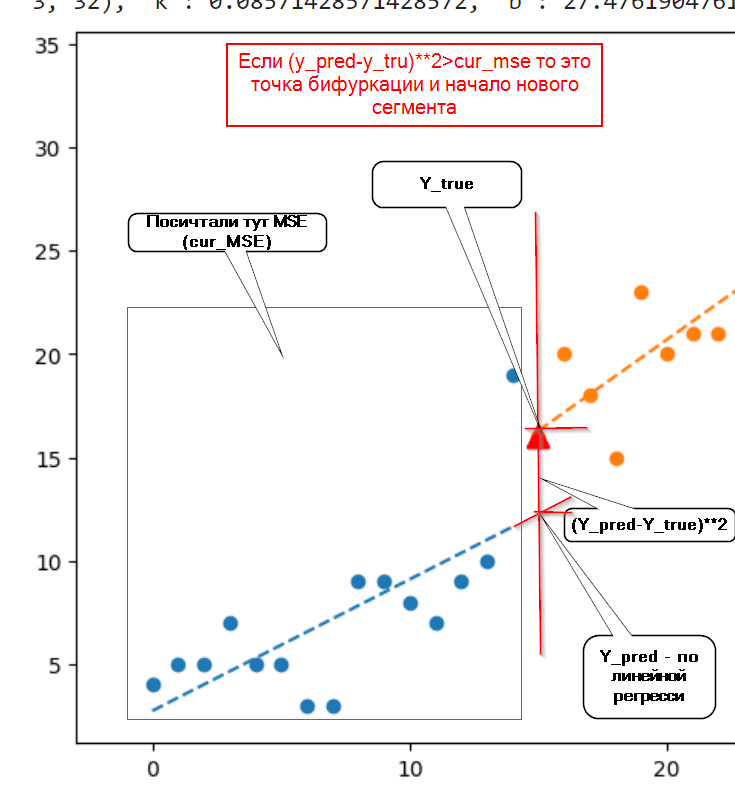

Можно использовать любую метрику. Например R2 и задать это как параметр функции

Важно ! Я ввел такой параметр min_segment_zize, который задает минимальное количество точек в синем прямоугольнике на рисунке. Линейную регрессию можно построить и по двум точкам, но тогда алгоритм просто разделит последовательность точек на отрезки по две точки. Более мение, сегментация получается начиная с 10ти точек. То есть в начале (или когда перешли на новый сегмент) мы просто добавляем min_segment_zize точек в выборку без всяких условий и лишь с (min_segment_zize+1)ой точки начинаем проверку условия по МSE: если разница между текущей точкой и предсказанием в квадрате больше MSE текущих точек и их линейной регресии, то это точка бифуркации и начало нового сегмента. Если нет - то добавляем ее в набор и обновляем линейную регрессию. 

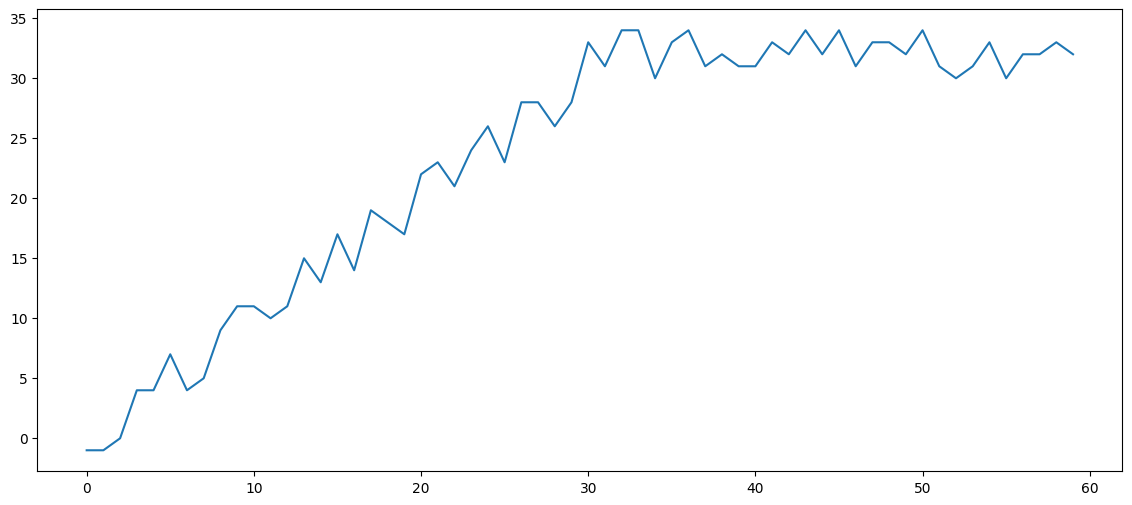

In [2]:
# Создадим какой то тренд данных с восхождением и с выходом на полочку
n_points=30
data_slopped = []
for n in range(n_points):
    data_slopped.append(n+random.randint(-2,+2))
data = np.concatenate ((np.array(data_slopped), np.random.randint(30,35, n_points)))
plt.plot(data)

In [3]:
# Стандартная библиотека sk_learn 
sk_lr = LinearRegression()

In [4]:
# Это уже функиця от меня.Идея разбить данные на сегменты, границами которых будут линии "перелома" 
# логистической прямой. Каждую новую точку сравниваем с предсказаанием по предыдцщим,
# если разность больше trashhold то сегмент заканчиваем, вносим точку в список точек перелома, и собираем набор
# данных для регрессии
# ВАЖНО! min_segment_zize=10 - минимальный (то есть начальоное количество точек в новом сегменте по которым будет строиться
# начальная линейная ргрессия) размер сегмента. Если сделать 2 точки то будет каждая треться точка помечаться.
def berak_trend_line_mse(data, min_segment_size=5):
    curr_y_list = []
    curr_X_list = []
    warn_points = []
    warn_index = []
    section_param = {}
    cur_pred_x = []
    treshhold = 2
    for index, point in enumerate(data):        
        cur_pred_x.clear()        
        if len(curr_y_list)<min_segment_size:            
            curr_y_list.append(point)
            curr_X_list.append(index)            
        else:
            X=np.array(curr_X_list).reshape((-1, 1))
            y=np.array(curr_y_list)
            sk_lr.fit(X,y)            
            cur_pred_x.append(index)
            cur_x = np.array(cur_pred_x).reshape((-1, 1))
            cur_mse = mean_squared_error(y, sk_lr.predict(X))
            cur_point_mse = (point-sk_lr.predict(cur_x))**2
            if cur_point_mse >= cur_mse:               
                section_param[index] = {'x': tuple(curr_X_list), 'y':tuple(curr_y_list), 'k':sk_lr.coef_[0], 'b':sk_lr.intercept_}
                warn_points.append(point)
                warn_index.append(index)                
                curr_y_list.clear()
                curr_X_list.clear()
                curr_y_list.append(point)
                curr_X_list.append(index)
            else:
                curr_y_list.append(point)
                curr_X_list.append(index)
    X=np.array(curr_X_list).reshape((-1, 1))
    y=np.array(curr_y_list)
    sk_lr.fit(X,y)
    section_param[index] = {'x': tuple(curr_X_list), 'y':tuple(curr_y_list), 'k':sk_lr.coef_[0], 'b':sk_lr.intercept_}
    return warn_index, warn_points, section_param

In [5]:
warn_index, warn_points, section_param = berak_trend_line_mse(data, min_segment_size=15)

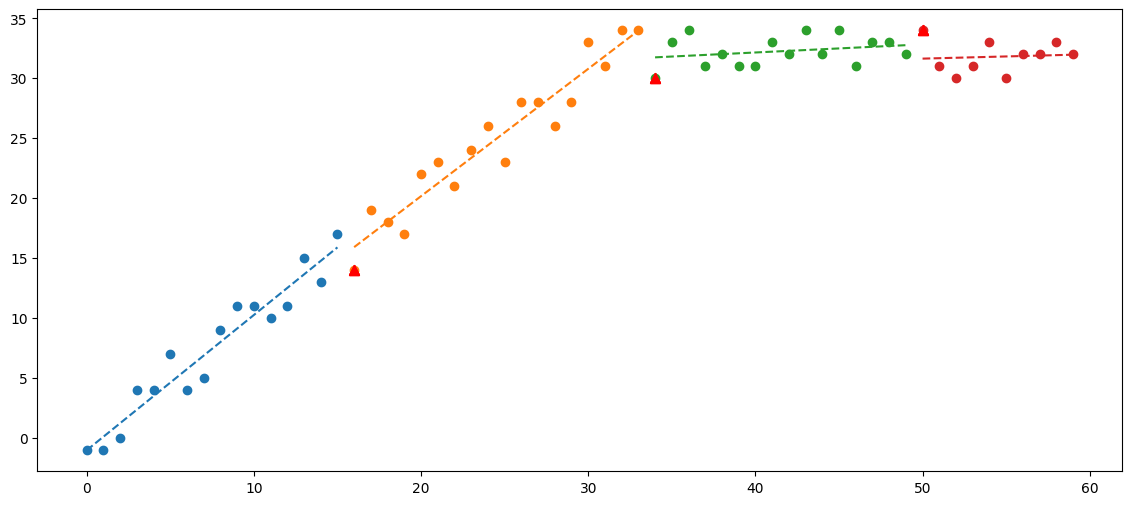

In [6]:
#Визуализация
for k,v in section_param.items():
    plt.scatter(x=v['x'] , y=v['y'])
    x = np.linspace(v['x'][0], v['x'][-1], 10)
    # Построение прямой
    y=v['k']*x+v['b']
    plt.plot(x, y, linestyle='--')
    plt.scatter(x=warn_index , y=warn_points, c ="red", marker='^', s = 50)
    #plt.plot(np.arange(x_left,x_right), arr_mean-treshhold, linestyle='--')   
    #plt.plot(np.arange(x_left,x_right), arr_mean+treshhold, linestyle='--')
    #x_left+=len(arr)

In [7]:
#Будем использовать данные по курсу пары BTC-USD. Источник данных https://www.kaggle.com/datasets/jessevent/all-crypto-currencies
btc_df = pd.read_csv('data/BTC-USD.csv', index_col=['timestamp'], parse_dates=['timestamp'])
# Удалим все столбцы, кроме "close"
btc_df.drop(['adjclose', 'open', 'high', 'volume', 'low'], axis= 1 , inplace= True)
# возьмем только первые 500 строк
data = btc_df.close[1500:3000].values


In [8]:
warn_index, warn_points, section_param = berak_trend_line_mse(data, min_segment_size=60)

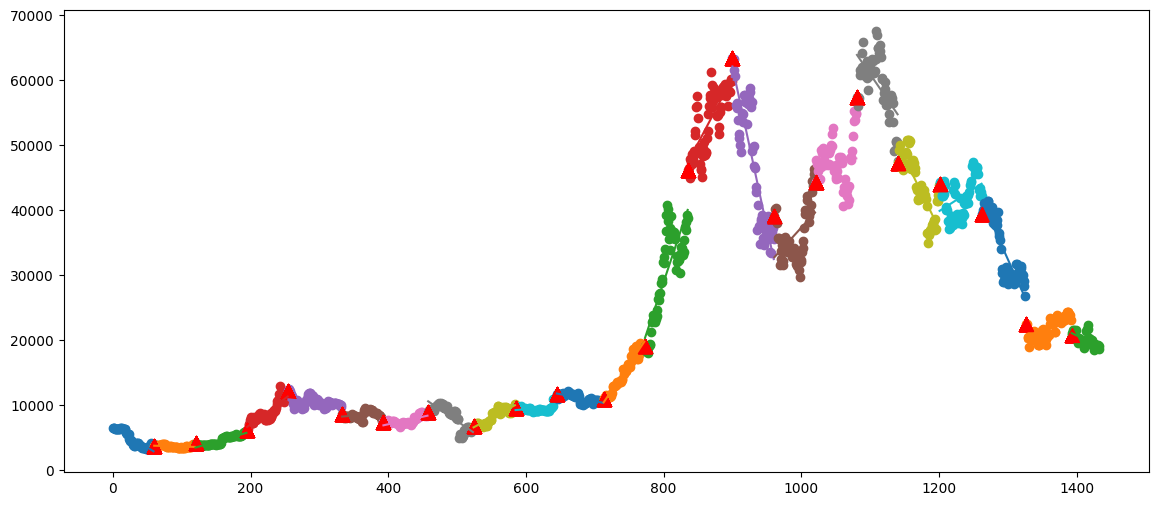

In [9]:
#Визуализация
for k,v in section_param.items():    
    plt.scatter(x=v['x'] , y=v['y'])
    x = np.linspace(v['x'][0], v['x'][-1], 10)
    # Построение прямой
    y=v['k']*x+v['b']
    plt.plot(x, y)
    plt.scatter(x=warn_index , y=warn_points, c ="red", marker='^', s = 100)
    #plt.plot(np.arange(x_left,x_right), arr_mean-treshhold, linestyle='--')   
    #plt.plot(np.arange(x_left,x_right), arr_mean+treshhold, linestyle='--')
    #x_left+=len(arr)